In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np

sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
import pandas as pd

In [3]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.95 # start with full 
print(config)

{'initial': 228.9405, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


In [4]:
ryan_pvt = pd.read_csv('ColdNight1_PowerVsTime.csv',delimiter=',', header= None)
ryan_pvt= ryan_pvt.T
ryan_pvt.columns = ryan_pvt.iloc[0]
#ryan_pvt = ryan_pvt.reset_index(drop=True)
ryan_pvt = ryan_pvt.drop(0)
ryan_pvt['Summed_all'] = ryan_pvt['PMU Q_SUM'].astype(float)+ryan_pvt['PFPS_Q_SUM'].astype(float)+ryan_pvt['PDU_Q_SUM'].astype(float)+ryan_pvt['DCB_Q_SUM'].astype(float)+ryan_pvt['Spectrometer_Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 1 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 2 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 3 Q_SUM'].astype(float) +ryan_pvt['Pre-Amp 4 Q_SUM'].astype(float)+ryan_pvt['Radio_SUM'].astype(float)
time_ryan = ryan_pvt['Nodes/Times'].iloc[:, 0] 
print(ryan_pvt)

0    Nodes/Times    PMU Q_SUM   PFPS_Q_SUM PDU_Q_SUM DCB_Q_SUM  \
1            0.0         1.48          8.0       0.6       2.0   
2       0.277778         1.48          8.0       0.6       2.0   
3       0.555556         1.48          8.0       0.6       2.0   
4       0.833333         1.48          8.0       0.6       2.0   
5       1.111111         1.48          8.0       0.6       2.0   
...          ...          ...          ...       ...       ...   
2361  655.555556         1.48          8.0       0.6       2.0   
2362  655.716667         1.48          8.0       0.6       2.0   
2363         MAX         1.48            8       0.6         2   
2364         MIN         0.92            1       0.6         2   
2365         AVG  1.193361558  5.695596952       0.6         2   

0    Spectrometer_Q_SUM Pre-Amp 1 Q_SUM Pre-Amp 2 Q_SUM Pre-Amp 3 Q_SUM  \
1                   0.0            0.86            0.86            0.86   
2                   0.0            0.86            0.86  

In [5]:
print(time_ryan[0:2362])
time_ryan = time_ryan[0:2362]

1              0.0
2         0.277778
3         0.555556
4         0.833333
5         1.111111
           ...    
2358    654.722222
2359         655.0
2360    655.277778
2361    655.555556
2362    655.716667
Name: Nodes/Times, Length: 2362, dtype: object


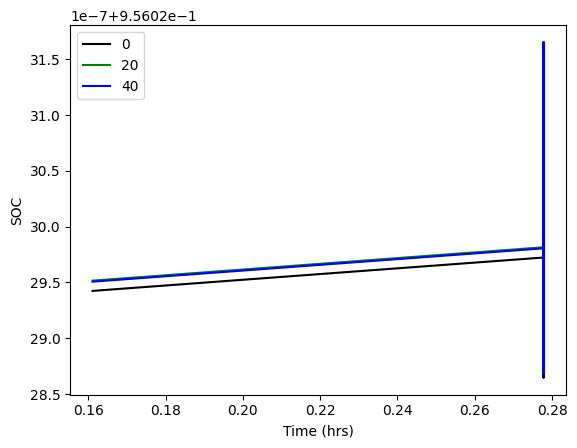

In [8]:
colors = ['k','g','b']
temperatures = [0, 20, 40]
plt.figure()

for j,T in enumerate(temperatures): ## we need this from Ryan
    B = hardware.Battery(config, verbose=False)
    B.set_temperature(T)
    energy = 0
    deltaT_list= []
    soc_values = []
    #while (B.SOC()>0.05):
    for i in range(len(time_ryan) - 1):
        deltaT = time_ryan.iloc[i+1] -time_ryan.iloc[i]
        deltaP = ryan_pvt['Summed_all'].iloc[i+1] -ryan_pvt['Summed_all'].iloc[i]
        #print(deltaT, deltaP)
        deltaT_list.append(deltaT)
        P = deltaP
        B.apply_power(-P,deltaT) # discharge at 1W
        energy += deltaT*P
        soc_values.append(B.SOC())
    #if B.SOC() <= 0.05:
        #break
    plt.plot(deltaT_list, soc_values, color = colors[j],label=T)
plt.ylabel('SOC')
plt.xlabel('Time (hrs)')
plt.legend()
plt.show() 

